#                                 Comparision of Traditional, Tandem and learning with rationale model

In [3]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
from sklearn.feature_selection import chi2


# Dont run this block everytime as it will empty the list in which data is being stored for taking the average.(Results for each run with different random seed)

In [4]:
total_accuracy_tradional_learning = []
total_accuracy_tandem_learning = []
total_accuracy_rationale_learning = []
total_auc_tradional = []
total_auc_tandem =[]
total_auc_rationale = []

# Reading the csv into dataframe   In order to get the average of all the result excute the blocks from below 5 times 

In [5]:
dataframe1 = pd.read_csv("E:\Tranparent machine learning\hotel-reviews.csv")
data = dataframe1['Description']

# Binarize the label

In [6]:
label = dataframe1['Is_Response'].map(lambda x : 1 if x == "happy" else 0)

# Use CountVectorizer to binarize the reviews using uni_gram and min_df =3

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
ct_vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=3,stop_words='english', binary=True)
X_data = ct_vectorizer.fit_transform(data)

In [8]:
feature_name = ct_vectorizer.get_feature_names()
print("the total number of features",len(feature_name))


the total number of features 18887


# Spiliting the data into train and test. 90% for test and 10% for training

In [9]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, label, test_size=0.9, random_state=217)

C:\Users\sunvi\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Number of positive and negative document found in training

In [10]:
X_train.shape

(3893, 18887)

In [11]:
X = X_train.toarray()
positive = X[y_train == 1]
negative = X[y_train == 0]
print("Number of positive instance in X_train",positive.shape[0])
print("Number of negative instance in X_train",negative.shape[0])

Number of positive instance in X_train 2690
Number of negative instance in X_train 1203


# Checking the accuracy of the classifier by fitting all the training data

In [12]:
from sklearn import linear_model
lr_clf_l2 = linear_model.LogisticRegression(penalty='l2')
#from sklearn.naive_bayes import MultinomialNB
#lr_clf_l2 = MultinomialNB()

In [13]:
model_without_rational = lr_clf_l2.fit(X_train,y_train )
print("accuracy of model without rationale for training",lr_clf_l2.score(X_train, y_train)*100)
print("accuracy of model without rationale for test",lr_clf_l2.score(X_test, y_test)*100)

accuracy of model without rationale for training 99.589005908
accuracy of model without rationale for test 84.6941978938


In [14]:
from sklearn import metrics
from sklearn.metrics import roc_curve , auc
pred = lr_clf_l2.predict_proba(X_test)[:,1]
fpr,tpr,_= metrics.roc_curve(y_test,pred)
auc=metrics.auc(fpr,tpr)
print("AUC of the whole model is ",auc)

AUC of the whole model is  0.901950445516


# Traditional learning

In [15]:
from sklearn import linear_model                              ##Comment and uncomment the classifier you want to use.
lr_clf_l2 = linear_model.LogisticRegression(penalty='l2')
#from sklearn.naive_bayes import MultinomialNB
#lr_clf_l2 = MultinomialNB()

# Fitting the traditional training model iteratively after each count of 5

In [16]:


accu_train_wor = []
accu_test_wor = []
y_wor_train = []
X_wor_train = None
total1 = []
count = 0
auc_tradional = []
total_count = 0
for i in range(0,200):
    count = count +1
    total_count = total_count + 1 
    X_wor_train = sp.vstack((X_wor_train,X_train[i]))        
    y_wor_train.append(y_train.iloc[i])
    if count == 5:
        count = 0
        total1.append(total_count)
        lr_clf_l2.fit(X_wor_train, np.array(y_wor_train))
        accu_train_wor.append(lr_clf_l2.score(X_wor_train,np.array(y_wor_train)))
        accu_test_wor.append(lr_clf_l2.score(X_test, y_test))
        pred = lr_clf_l2.predict_proba(X_test)[:,1]
        fpr,tpr,_= metrics.roc_curve(y_test,pred)
        auc_tradional.append(metrics.auc(fpr,tpr))

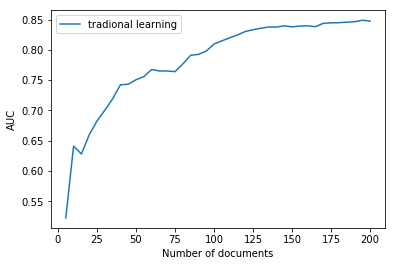

In [17]:
import matplotlib.pyplot as plt
plt.plot(total1,auc_tradional,label = "tradional learning")

plt.legend()
plt.xlabel('Number of documents')
plt.ylabel('AUC')
plt.show()

# Chi sqaure to get the list of words

In [18]:
chi2_scores = chi2(X_train, y_train)
feature_scores = chi2_scores[0]
nan_index  = np.nonzero(np.isnan(feature_scores))
feature_scores[nan_index] = 0
feature_rank = np.argsort(feature_scores)[::-1]

In [19]:
X_train = X_train.toarray() ###Converting X_train to array to check the number of positive and negative counts in one line

# Dividing the words as positive or negative rationale depending upon its occurence in positive and negative label

In [20]:
index_negative = []
index_positive =  []
index_overall = []
rational = []
def count_positive_negative(X_train,y_train,feature_rank):
    negative_rational = []
    positive_rational = []
    
    for i in feature_rank[:100]:
    
        negcount = np.sum(X_train[y_train==0,i])
        poscount = np.sum(X_train[y_train==1,i])

        if negcount > poscount:

            if negcount/poscount > 3:                        ### Dividing the total negative count by positive count if the ratio is greater
                negative_rational.append(feature_name[i])    ### than 3 only then consider it as negative rationale. This done to
                rational.append(feature_name[i])             ### make very clear distinction between the negative and positive words.
                index_negative.append(i)
                index_overall.append(i)
        else:

            if poscount/negcount > 3:
                positive_rational.append(feature_name[i])
                rational.append(feature_name[i])
                index_positive.append(i)
                index_overall.append(i)
            
    print("\n\npositive_rational",positive_rational,len(positive_rational))
    print("\n\n negative_rational",negative_rational,len(negative_rational))
    print("\n\n rational",rational,len(rational))
    

# Rationale generated

In [21]:
count_positive_negative(X_train,y_train,feature_rank)



positive_rational ['great', 'helpful', 'wonderful', 'perfect', 'excellent', 'friendly', 'loved', 'highly', 'comfortable', 'spacious', 'staff', 'amazing', 'definitely', 'enjoyed'] 14


 negative_rational ['dirty', 'worst', 'finally', 'carpet', 'broken', 'poor', 'rude', 'stains', 'horrible', 'disgusting', 'terrible', 'filthy', 'worn', 'carpets', 'awful', 'shabby', 'peeling', 'clearly', 'stained', 'worse', 'dirt', 'disappointing', 'smoke', 'hairs', 'poorly', 'shut'] 26


 rational ['dirty', 'worst', 'finally', 'carpet', 'great', 'broken', 'poor', 'helpful', 'rude', 'wonderful', 'perfect', 'stains', 'horrible', 'disgusting', 'excellent', 'terrible', 'friendly', 'filthy', 'worn', 'carpets', 'awful', 'loved', 'shabby', 'highly', 'comfortable', 'peeling', 'spacious', 'clearly', 'stained', 'staff', 'amazing', 'worse', 'definitely', 'dirt', 'disappointing', 'smoke', 'hairs', 'poorly', 'shut', 'enjoyed'] 40


C:\Users\sunvi\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: divide by zero encountered in longlong_scalars


In [22]:
X_test = X_test.toarray()

# Count of negative rationale in training set

In [24]:
for i in index_negative:
    sum = np.sum(X_train[:,i])
    print("the negative word is ",feature_name[i],"and count in training set is ",sum)

the negative word is  dirty and count in training set is  151
the negative word is  worst and count in training set is  88
the negative word is  finally and count in training set is  113
the negative word is  carpet and count in training set is  115
the negative word is  broken and count in training set is  60
the negative word is  poor and count in training set is  86
the negative word is  rude and count in training set is  82
the negative word is  stains and count in training set is  53
the negative word is  horrible and count in training set is  61
the negative word is  disgusting and count in training set is  36
the negative word is  terrible and count in training set is  60
the negative word is  filthy and count in training set is  35
the negative word is  worn and count in training set is  68
the negative word is  carpets and count in training set is  46
the negative word is  awful and count in training set is  46
the negative word is  shabby and count in training set is  29
the 

# Count of negative rationale in test set

In [626]:
for i in index_negative:
    sum = np.sum(X_test[:,i])
    print("the negative word is ",feature_name[i],"and count in test set is ",sum)

the negative word is  dirty and count in test set is  1211
the negative word is  worst and count in test set is  771
the negative word is  finally and count in test set is  1008
the negative word is  carpet and count in test set is  1011
the negative word is  broken and count in test set is  644
the negative word is  poor and count in test set is  863
the negative word is  rude and count in test set is  812
the negative word is  stains and count in test set is  367
the negative word is  horrible and count in test set is  571
the negative word is  disgusting and count in test set is  277
the negative word is  terrible and count in test set is  679
the negative word is  filthy and count in test set is  291
the negative word is  worn and count in test set is  580
the negative word is  carpets and count in test set is  318
the negative word is  awful and count in test set is  398
the negative word is  shabby and count in test set is  187
the negative word is  peeling and count in test set 

# Count of positive rationale in training set

In [633]:
for i in index_positive:
    sum = np.sum(X_train[:,i])
    print("the negative word is ",feature_name[i],"and count in test set is ",sum)

the negative word is  great and count in test set is  1689
the negative word is  helpful and count in test set is  830
the negative word is  wonderful and count in test set is  372
the negative word is  perfect and count in test set is  347
the negative word is  excellent and count in test set is  509
the negative word is  friendly and count in test set is  981
the negative word is  loved and count in test set is  270
the negative word is  highly and count in test set is  203
the negative word is  comfortable and count in test set is  917
the negative word is  spacious and count in test set is  322
the negative word is  staff and count in test set is  1946
the negative word is  amazing and count in test set is  223
the negative word is  definitely and count in test set is  475
the negative word is  enjoyed and count in test set is  272


# Count of positive rationale in test set

In [634]:
for i in index_positive:
    sum = np.sum(X_test[:,i])
    print("the positive word is ",feature_name[i],"and count in test set is ",sum)

the positive word is  great and count in test set is  14915
the positive word is  helpful and count in test set is  7290
the positive word is  wonderful and count in test set is  2967
the positive word is  perfect and count in test set is  3032
the positive word is  excellent and count in test set is  4326
the positive word is  friendly and count in test set is  8893
the positive word is  loved and count in test set is  2228
the positive word is  highly and count in test set is  1750
the positive word is  comfortable and count in test set is  8118
the positive word is  spacious and count in test set is  2814
the positive word is  staff and count in test set is  17154
the positive word is  amazing and count in test set is  1844
the positive word is  definitely and count in test set is  4008
the positive word is  enjoyed and count in test set is  2228


In [25]:
from sklearn import linear_model                                    # Select the classifier which you want to import.Just comment 
clf_with_tandem = linear_model.LogisticRegression(penalty='l2')     # and uncomment.
#from sklearn.naive_bayes import MultinomialNB
#clf_with_tandem = MultinomialNB()

In [26]:
from scipy import sparse
X_train = sparse.csr_matrix(X_train,dtype=float)   ## Converting X_train back to sparse matrix and in float so that value of 0.01 can be stored
X_test = sparse.csr_matrix(X_test)

# TANDEM learning

# Fitting the tandem training model iteratively after each count of 5. In this model we multiply the all the features (matching with rationale) of the document by 1 and all the other non matching feature with 0.01

In [27]:

X_train_copy = X_train.copy()
training_accuracy = []
testing_accuracy = []
y_final_train =[]
X_final_train = None
count = 0
total_count = 0
count_total =[]
countnumber = 1
auc_tandem = []
for i in range(0,200):
    count = count + 1
    total_count = total_count + 1
    features = X_train_copy[i].indices
    if y_train.iloc[i] == 0:
        for f in features:
            if f in index_negative:
                values= 1 * X_train_copy[i,f]
                X_train_copy[i,f] = values
            else:
                vals = 0.01 * X_train_copy[i,f]
                X_train_copy[i,f] =  vals

    else:
        
        for f in features:
            if f in index_positive:
                X_train_copy[i,f] = 1 * X_train_copy[i,f]
            else:
                X_train_copy[i,f] = 0.01 * X_train_copy[i,f]
    X_final_train = sp.vstack((X_final_train,X_train_copy[i]))        
    y_final_train.append(y_train.iloc[i])
    
    if count == 5:
        count = 0
        count_total.append(total_count)
        clf_with_tandem.fit(X_final_train, y_final_train)
        training_accuracy.append(clf_with_tandem.score(X_final_train, y_final_train))
        testing_accuracy.append(clf_with_tandem.score(X_test, y_test))
        pred = clf_with_tandem.predict_proba(X_test)[:,1]
        fpr,tpr,_= metrics.roc_curve(y_test,pred)
        auc_tandem.append(metrics.auc(fpr,tpr))
        

# Learning with rationale

# Fitting the rationale  training model iteratively after each count of 5. In this model we multiply the only one of the features in document , matching with rationale document with 1 and all the other features of the document with 0.01

In [28]:
from sklearn import linear_model                                      ### Comment and un-commnet to change the classifier   
clf_with_rationale = linear_model.LogisticRegression(penalty='l2')
#from sklearn.naive_bayes import MultinomialNB
#clf_with_rationale = MultinomialNB()

In [29]:
import random
def randomfeature(features,index):           ##### This function is select the one rationale at random from all the matched rationale
    matched = (set(features) & set(index))
    if len(matched) > 0:
        return random.sample(matched,1)
    else:
        return -1 

In [30]:

X_train_rationale = X_train.copy()
training_accuracy_rationale = []
testing_accuracy_rationale = []
y_final_train_rationale =[]
X_final_train_rationale = None
count3 = 0
total_count3 = 0
count_total3 =[]
countnumber = 1
auc_rationale = []
for i in range(0,200):
    count3 = count3 + 1
#    print(i)
    total_count3 = total_count3 + 1
    features = X_train_rationale[i].indices
    if y_train.iloc[i] == 0:
#        print(i)
        f = randomfeature(features,index_negative)
        for feats in features:
            if f == feats:
                
                values= 1 * X_train_rationale[i,feats]
                X_train_rationale[i,feats] = values
#                print(X_train_rationale[i,feats],i,f,feats)
            else:
                vals = 0.01 * X_train_rationale[i,feats]
                X_train_rationale[i,feats] =  vals
#                print(X_train_rationale[i,feats],i,f,feats)

    else:
        f = randomfeature(features,index_positive)
        for feats in features:
            if f == feats:
                X_train_rationale[i,feats] = 1 * X_train_rationale[i,feats]
#                print("positive",X_train_rationale[i,feats],i,f,feats)
            else:
                X_train_rationale[i,feats] = 0.01 * X_train_rationale[i,feats]
#                print("positive",X_train_rationale[i,feats],i,f,feats)
    X_final_train_rationale = sp.vstack((X_final_train_rationale,X_train_rationale[i]))        
    y_final_train_rationale.append(y_train.iloc[i])
    
    if count3 == 5:
        count3 = 0
        count_total3.append(total_count3)
        clf_with_rationale.fit(X_final_train_rationale, y_final_train_rationale)
        training_accuracy_rationale.append(clf_with_rationale.score(X_final_train_rationale, y_final_train_rationale))
        testing_accuracy_rationale.append(clf_with_rationale.score(X_test, y_test))
        pred = clf_with_rationale.predict_proba(X_test)[:,1]
        fpr,tpr,_= metrics.roc_curve(y_test,pred)
        auc_rationale.append(metrics.auc(fpr,tpr))
        

# Plotting of accuracy curve

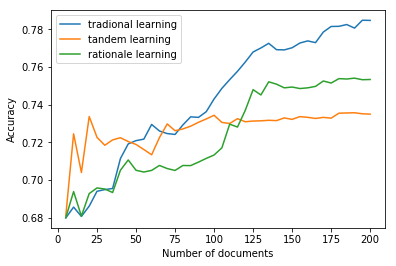

In [31]:
import matplotlib.pyplot as plt
plt.plot(total1,accu_test_wor,label = "tradional learning")
plt.plot(count_total,testing_accuracy,label = "tandem learning")
plt.plot(count_total3,testing_accuracy_rationale,label ="rationale learning")
plt.legend()
plt.xlabel('Number of documents')
plt.ylabel('Accuracy')
plt.show()

# Plotting of the AUC curve

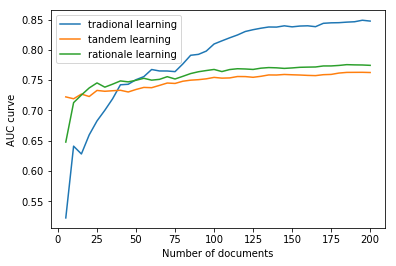

In [32]:
import matplotlib.pyplot as plt
plt.plot(total1,auc_tradional,label = "tradional learning")
plt.plot(count_total,auc_tandem,label = "tandem learning")
plt.plot(count_total3,auc_rationale,label ="rationale learning")
plt.legend()
plt.xlabel('Number of documents')
plt.ylabel('AUC curve')
plt.show()

In [33]:
total_accuracy_tradional_learning.append(accu_test_wor)
total_accuracy_tandem_learning.append(testing_accuracy)
total_accuracy_rationale_learning.append(testing_accuracy_rationale)
total_auc_tradional.append(auc_tradional)
total_auc_tandem.append(auc_tandem)
total_auc_rationale.append(auc_rationale)

In [34]:
len(total_accuracy_tradional_learning)

1

# Takeing the average of 5 runs:  Execute only after running the above code 5 times to get average accuracy graph

In [35]:
total_accuracy_tradional_learning = np.asarray(total_accuracy_tradional_learning)
total_accuracy_tandem_learning = np.asarray(total_accuracy_tandem_learning)
total_accuracy_rationale_learning = np.asarray(total_accuracy_rationale_learning)
total_auc_tradional = np.asarray(total_auc_tradional)
total_auc_tandem = np.asarray(total_auc_tandem)
total_auc_rationale = np.asarray(total_auc_rationale)

In [36]:
average_total_accuracy_tradional_learning = np.mean(total_accuracy_tradional_learning,axis =0 )
average_total_accuracy_tandem_learning = np.mean(total_accuracy_tandem_learning,axis =0)
average_total_accuracy_rationale_learning = np.mean(total_accuracy_rationale_learning,axis =0)
average_auc_tradional = np.mean(total_auc_tradional,axis = 0)
average_auc_tandem = np.mean(total_auc_tandem,axis = 0)
average_auc_rationale  = np.mean(total_auc_rationale,axis = 0)

In [441]:
len(average_total_accuracy_tradional_learning)

40

# Plotting of accuracy curve after taking the average 

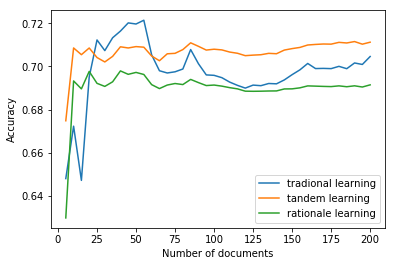

In [442]:
import matplotlib.pyplot as plt
plt.plot(total1,average_total_accuracy_tradional_learning,label = "tradional learning")
plt.plot(count_total,average_total_accuracy_tandem_learning,label = "tandem learning")
plt.plot(count_total3,average_total_accuracy_rationale_learning,label ="rationale learning")
plt.legend()
plt.xlabel('Number of documents')
plt.ylabel('Accuracy')
plt.show()

# Plotting of AUC curve after taking the average 

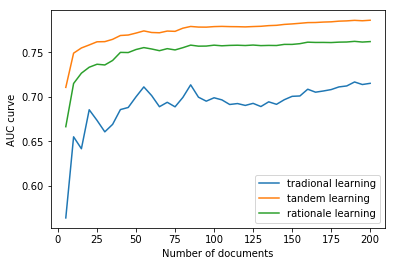

In [565]:
import matplotlib.pyplot as plt
plt.plot(total1,average_auc_tradional,label = "tradional learning")
plt.plot(count_total,average_auc_tandem,label = "tandem learning")
plt.plot(count_total3,average_auc_rationale,label ="rationale learning")
plt.legend()
plt.xlabel('Number of documents')
plt.ylabel('AUC curve')
plt.show()